In [2]:
from IPython.display import display, HTML
display(HTML ("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}""
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# Quiz : 경주여행과 전주여행에 대해 최빈단어 시각화와 유사도 분석
- (1) naver open API를 활용하여 네이버지식인 "전주여행", "경주여행"를 각각 500건씩 검색 백업
    * replace(), re.sum()이용
    * 백업 파일 결과 : 검색어, no, title, link, description, total_text(title+' '+description)
- (2) 품사태깅 백업(naver_pos.csv)
    * query, no, token, pos
- (3) 명사만 추출
    * query, token, pos
- (4) 빈도분석 백업(naver_pos_nouns_count.csv)
    * token, 경주빈도, 전주빈도, 빈도합
- (5) 빈도 시각화(워드클라우드, Text.plot)
    * 워드클라우드 이미지 저장
- (6) 단어간 유사도 분석(Word2Vec, 연관분석)
# 1. naver open API 활용

In [3]:
# .env 가져오기(방법1)
from dotenv import load_dotenv
import os
load_dotenv()
# print(os.getenv('CLIENT_ID'))
# print(os.getenv('CLIENT_SECRET'))

True

In [5]:
# .env 가져오기(방법2)
from decouple import config
# print(config('CLIENT_ID'))
# print(config('CLIENT_SECRET'))

In [7]:
import os
import sys
import urllib.request
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
encText = urllib.parse.quote("경주 여행")
url = "https://openapi.naver.com/v1/search/blog?query=" + encText # JSON 결과
# url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # XML 결과
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request)
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)

{
	"lastBuildDate":"Tue, 02 Dec 2025 14:38:43 +0900",
	"total":1003198,
	"start":1,
	"display":10,
	"items":[
		{
			"title":"내 마음대로 기록하는 <b>경주여행<\/b> 2박3일",
			"link":"https:\/\/blog.naver.com\/hellobear28\/224089271601",
			"description":"내 마음대로 기록하는 <b>경주여행<\/b> 2박3일 지난 주말, 경주로 2박3일 여행 다녀왔어요. 사실 다른 일 때문에 갔는데 겸사겸사 여행도 하고 왔어요. 경주는 곰님과 벌써 세번째! 연애 할 때 여행으로 웨딩스냅촬영으로... ",
			"bloggername":"unique_라떼곰",
			"bloggerlink":"blog.naver.com\/hellobear28",
			"postdate":"20251126"
		},
		{
			"title":"<b>경주여행<\/b>, 뚜벅이로 숙소와 시장을 지나 시내를 걷는 혼자 하루... ",
			"link":"https:\/\/blog.naver.com\/dorothy_bet\/224094425710",
			"description":"이어지는 동선이라 혼자 <b>경주여행<\/b>하는 뚜벅이 분들께 특히 잘 맞는 하루 였어요. 가볍게 걸어볼 만한 경주 시내 루트 찾는다면 이 흐름 그대로 참고해보셔도 좋아요. #<b>경주여행<\/b> #성동시장 #경주뚜벅이여행",
			"bloggername":"강원도, 1인 3색",
			"bloggerlink":"blog.naver.com\/dorothy_bet",
			"postdate":"20251201"
		},
		{
			"title":"아이랑 <b>경주 여행<\/b> 코스 불국사 해설 예약,시간,주차",
			"link":"https:\/\/blog.naver.com\/ohhhzzang\/224072732824",
			"descriptio

In [15]:
# 방법1
import requests
import pandas as pd
import json # response텍스트를 json스타일의 딕셔너리로
import re  # 정규표현식
from html import unescape # description에 &lt;등의 특수문자를 <(문자)로 변경

client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
query = '경주 여행'
start = 1
headers = {
    'X-Naver-Client-Id':client_id,
    'X-Naver-Client-Secret':client_secret
}
# url = f'https://openapi.naver.com/v1/search/kin?query={query}&display=100&start={start}'
# response = requests.get(url, headers=headers)
url = 'https://openapi.naver.com/v1/search/kin'
params = {'query':query, 'display':100, 'start':start}
response = requests.get(url, params=params, headers=headers)
# print(response.text[:500])
# items = json.loads(response.text)['items']
items = response.json()['items']
print(len(items))

100


In [20]:
# title, link, description 추출(b태그삭제, 특수문자조정(&gt; -> >), 정규표현식을 이용한 한글추출 )
item = items[97]
title = item.get('title').replace('<b>', '').replace('</b>', '')
link = item['link']
description = item.get('description').replace('<b>', '').replace('</b>', '')
# html 특수 문자 처리
description = unescape(description)
# 정규표현식 : 알파벳, 숫자, 한글만 남기고 나머지는 제거
description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
description = re.sub('\s+', ' ', description)
print(title, link, description)

경주 여행지 추천 https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90111&docId=261370795&qb=6rK97KO8IOyXrO2WiQ==&enc=utf8  2 부산을 벗어난 경주 여행지 알려주세요 3 당일치기로 경주 여행코스 밑에 자세하게 권역별로 여행코스를 소개했습니다 경주여행이 처음이라면 대릉원 첨성대 참고로 쭈니아빠 블로그를 방문하시면 경주여행 


In [18]:
def get_search_element_return(query, start):
    headers = {
    'X-Naver-Client-Id':client_id,
    'X-Naver-Client-Secret':client_secret
    }
    #url = f"https://openapi.naver.com/v1/search/kin?query={query}&display=100&start={start}"
    #response = requests.get(url, headers=headers)
    url = "https://openapi.naver.com/v1/search/kin"
    params = {'query':query, 'display':100, 'start':start}
    response = requests.get(url, params=params, headers=headers)
    #print(response.text[:500])
    #items = json.loads(response.text)['items']
    items = response.json()['items']
    result = [] # 검색할 정보를 append할 리스트
    for i,item in enumerate(items):
        title = item.get('title').replace('<b>', ' ').replace('</b>', ' ')
        link = item.get('link')
        description = item.get('description').replace('<b>', ' ').replace('</b>', ' ')
        # 특수문자처리
        description = unescape(description)
        # 영문자, 숫자, 한글을 제외한 문자 제거
        description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
        description = re.sub('\s+', ' ', description)
        result.append({
            'query':query,
            'no':(start-1)*100 + i+1,
            'title':title,
            'link':link,
            'description':description,
            'total_text':title+' '+description
        })
    return result

In [21]:
get_search_element_return('경주 여행', 2)

[{'query': '경주 여행',
  'no': 101,
  'title': ' 경주 여행  강수량 45% 비 오는거겠죠 ?',
  'link': 'https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90111&docId=488183062&qb=6rK97KO8IOyXrO2WiQ==&enc=utf8',
  'description': '다음주 27일 수요일에 경주 여행 가는데 날씨를 찾아보니 45퍼나 되던데 연달아 비 소식도 잡혀있고 비 오는거 비 오는 날의 운치를 즐길 수 있는 코스를 미리 생각해두시면 좋을 것 같습니다 즐거운 경주 여행 되시길 바랍니다 ',
  'total_text': ' 경주 여행  강수량 45% 비 오는거겠죠 ? 다음주 27일 수요일에 경주 여행 가는데 날씨를 찾아보니 45퍼나 되던데 연달아 비 소식도 잡혀있고 비 오는거 비 오는 날의 운치를 즐길 수 있는 코스를 미리 생각해두시면 좋을 것 같습니다 즐거운 경주 여행 되시길 바랍니다 '},
 {'query': '경주 여행',
  'no': 102,
  'title': '6~7월  경주 여행 에서 꼭 가봐야 할 명소는?',
  'link': 'https://kin.naver.com/qna/detail.naver?d1id=9&dirId=90105&docId=486500596&qb=6rK97KO8IOyXrO2WiQ==&enc=utf8',
  'description': ' 질문하신 경주 여행 명소 관련 답변 드리도록 하겠습니다 6 7월에 방문하기 좋은 경주 명소로는 동궁과 월지 석굴암 경주 동궁원 월정교 오류고아라해변 등이 있습니다 여행하시는데 참고하시기 바랍니다 도움이 되셨다면 채택 ',
  'total_text': '6~7월  경주 여행 에서 꼭 가봐야 할 명소는?  질문하신 경주 여행 명소 관련 답변 드리도록 하겠습니다 6 7월에 방문하기 좋은 경주 명소로는 동궁과 월지 석굴암 경주 동궁원 월정교 오류고아라해변 등이 있습니다 여행하시는데 참고하시기 바

In [26]:
import time
result_total = [] # 모든 검색 결과
queries = ['전주 여행', '경주 여행']
max_start = 5
for query in queries:
    for start in range(1, max_start+1):
        print(start, query, '읽는 중')
        result_total.extend(get_search_element_return(query, start))
        time.sleep(0.5)
df= pd.DataFrame(result_total)
df.to_csv('data/naver.csv', index=False)

1 전주 여행 읽는 중
2 전주 여행 읽는 중
3 전주 여행 읽는 중
4 전주 여행 읽는 중
5 전주 여행 읽는 중
1 경주 여행 읽는 중
2 경주 여행 읽는 중
3 경주 여행 읽는 중
4 경주 여행 읽는 중
5 경주 여행 읽는 중


# 2. 품사태깅 백업
- query, no, token, pos

In [28]:
import pandas as pd
df = pd.read_csv('data/naver.csv')
df.tail(2)

,query,no,title,link,description,total_text
998,경주 여행,499,경주 여행 가면 볼거 많겠죠??,https://kin.naver.com/qna/detail.naver?d1id=9&...,중학생인데 경주 여행 가볼려고 하는데 볼거 많겠죠 경주 가볼만한곳 입니다 불국사 첨...,경주 여행 가면 볼거 많겠죠?? 중학생인데 경주 여행 가볼려고 하는데 볼거 많겠죠...
999,경주 여행,500,경주여행 !!,https://kin.naver.com/qna/detail.naver?d1id=9&...,경주 여행 을 가려고 하는데 혹시 경주에 폴라로이드 카메라 대여 할 수 있는곳이나...,경주여행 !! 경주 여행 을 가려고 하는데 혹시 경주에 폴라로이드 카메라 대여 ...


In [32]:
df_list=df[['query', 'no', 'total_text']].values.tolist()
df_list[::500]

[['전주 여행',
  1,
  '25년10월5,6,7일  전주여행   전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가기 좋은 시점이에요 추석에는 문 연 곳이 적을 수 있지만 전주 한옥마을이나 전주비빔밥 맛집은 추천해용 차는 밀릴 가능성이 높으니 미리 출발하는 '],
 ['경주 여행',
  1,
  'APEC 기간  경주여행  APEC 기간 경주여행 어떻게 생각하시나요 APEC 기간에 경주여행 은 좋은 방법이에요 역사와 문화가 가득한 도시에서 특별한 경험을 할 수 있을 거에요 즐거운 여행 되세요 ']]

In [43]:
from mecab import MeCab
analyzer = MeCab()
postagged_list = [] # query, no, token, pos 딕셔너리 list
stopwords = {'전주', '경주', '여행'}
for i,row in enumerate(df_list):
    query = row[0]
    no = row[1]
    text = row[2]
    tagged_text = analyzer.pos(text)
#     if i%250==0:
#         print("{}의 {}번째 품사탱깅결과 : {}개".format(query, no, len(tagged_text)))
    for token, pos in tagged_text:
        #if token not in stopwords and pos in select_pos: # 불용어제외한 명사
        if token not in stopwords: # 불용어 제외, 한글자초과만 append
            postagged_list.append({
                'query':query,
                'no':no,
                'token':token,
                'pos':pos
            })
df_postagged = pd.DataFrame(postagged_list)
df_postagged.to_csv('data/naver_pos.csv', index=False, encoding='cp949')

# 3. 명사만 추출

In [47]:
import pandas as pd
df_postagged = pd.read_csv('data/naver_pos.csv', encoding='cp949')
df_postagged.head(1)

,query,no,token,pos
0,전주 여행,1,25,SN


In [50]:
select_pos = ['NNG', 'NNP'] # mecab의 명사 pos tag
df_nouns=df_postagged[df_postagged['pos'].isin(select_pos)]
df_nouns.to_csv('data/naver_pos_nouns.csv', index=False, encoding='cp949')

# 4. 빈도분석
- token 경주빈도 전주빈도 빈도합

In [57]:
df_nouns = pd.read_csv('data/naver_pos_nouns.csv', encoding='cp949')
df_nouns.head()

,query,no,token,pos
0,전주 여행,1,곳,NNG
1,전주 여행,1,추천,NNG
2,전주 여행,1,부탁,NNG
3,전주 여행,1,아이,NNG
4,전주 여행,1,시점,NNG


In [73]:
df_nouns.groupby(['query','token'], as_index=False)['pos'].count()

,query,token,pos
0,경주 여행,가격,5
1,경주 여행,가능,30
2,경주 여행,가보세요,10
3,경주 여행,가본적,5
4,경주 여행,가시,5
...,...,...,...
996,전주 여행,효율,5
997,전주 여행,후,5
998,전주 여행,휴가,5
999,전주 여행,휴무,5


In [55]:
df_token_grp = df_nouns.groupby('query')['token'].value_counts()
df_token_grp = df_token_grp.reset_index(name='token_count')

In [56]:
df_token_grp.head()

,query,token,token_count
0,경주 여행,코스,447
1,경주 여행,추천,424
2,경주 여행,계획,151
3,경주 여행,곳,134
4,경주 여행,맛집,133


In [59]:
df_gj = df_token_grp.loc[df_token_grp['query']=='경주 여행',['token', 'token_count']]
df_jj = df_token_grp.loc[df_token_grp['query']=='전주 여행',['token', 'token_count']]
df_gj.shape, df_jj.shape

((535, 2), (466, 2))

In [61]:
df_gj.head()

,token,token_count
0,코스,447
1,추천,424
2,계획,151
3,곳,134
4,맛집,133


In [62]:
df_jj.head()

,token,token_count
535,코스,459
536,곳,433
537,봉,330
538,맛집,322
539,여수,315


In [69]:
#df_gj(경주 명상 출현횟수), df_jj(전주 명사 출현 횟수) 병합
import numpy as np
df_mrg = pd.merge(df_gj, df_jj, on='token', how='outer')
df_mrg.columns = ['token', '경주빈도', '전주빈도']
df_mrg.fillna(0, inplace=True)
df_mrg['경주빈도']= df_mrg['경주빈도'].astype('int')
df_mrg['전주빈도']= df_mrg['전주빈도'].astype(np.int32)
df_mrg.head()

,token,경주빈도,전주빈도
0,코스,447,459
1,추천,424,289
2,계획,151,64
3,곳,134,433
4,맛집,133,322


In [71]:
df_mrg['빈도합'] = df_mrg['경주빈도'] + df_mrg['전주빈도']
df_mrg['경주비율'] = df_mrg['경주빈도']/df_mrg['빈도합']
df_mrg['전주비율'] = df_mrg['전주빈도']/df_mrg['빈도합']
df_mrg['경주비율'] = df_mrg['경주비율'].apply(lambda x : "{:.2%}".format(x))
df_mrg['전주비율'] = df_mrg['전주비율'].apply(lambda x : "{:.2%}".format(x))
df_mrg.to_csv('data/naver_pos_nouns_count.csv', index=False, encoding='cp949')

# 5. 빈도 시각화(워드 클라우드, Text)
- 전주여행 워드클라우드/경주여행 워드클라우드

In [72]:
df_nouns = pd.read_csv('data/naver_pos_nouns.csv', encoding='cp949')
df_nouns.loc[::5000]

,query,no,token,pos
0,전주 여행,1,곳,NNG
5000,전주 여행,273,현대,NNG
10000,경주 여행,54,지,NNG
15000,경주 여행,377,추천,NNG


In [79]:
df_gj_noun_list = df_nouns.loc[df_nouns['query'] == '경주 여행','token'].to_list()
df_jj_noun_list = df_nouns.loc[df_nouns['query'] == '전주 여행','token'].to_list()
gj_text = ' '.join(df_gj_noun_list)
jj_text = ' '.join(df_jj_noun_list)

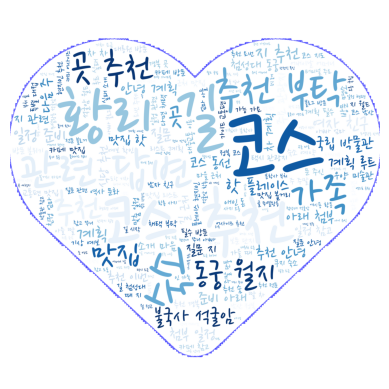

In [86]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
img = Image.open('data/heart.jpg')
mask = np.array(img)

wordcloud = WordCloud(
    font_path='data/NanumPenScript-Regular.ttf',
    background_color='white',
    colormap='Blues',
    collocations=True, # 특정단어가 자주 같이 나오면 같이 뿌려 ex 황리길
    max_words=200,
    scale=2, # 이미지 크기의 비율(파일 저장시)
    mask=mask,
    contour_color='blue',
    contour_width=1
).generate(gj_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [87]:
# 생성된 wordcloud 저장
wordcloud.to_file('data/naver_경주.jpg')

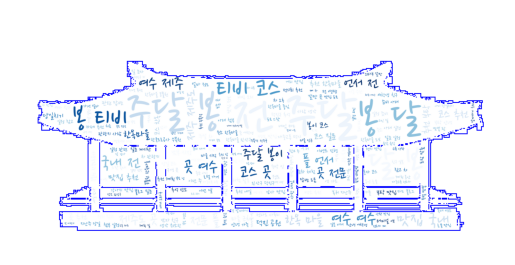

In [89]:
img = Image.open('data/korea-house-black-fill.png')
mask = np.array(img)

wordcloud = WordCloud(
    font_path='data/NanumPenScript-Regular.ttf',
    background_color='white',
    colormap='Blues',
    collocations=True, # 특정단어가 자주 같이 나오면 같이 뿌려 ex 황리길
    max_words=200,
    scale=2, # 이미지 크기의 비율(파일 저장시)
    mask=mask,
    contour_color='blue',
    contour_width=1
).generate(jj_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [90]:
# 생성된 wordcloud 저장
wordcloud.to_file('data/naver_전주.jpg')

# 빈도수 시각화(nltk.Text)

In [91]:
df_gj_noun_list = df_nouns.loc[df_nouns['query'] == '경주 여행','token'].to_list()
df_jj_noun_list = df_nouns.loc[df_nouns['query'] == '전주 여행','token'].to_list()

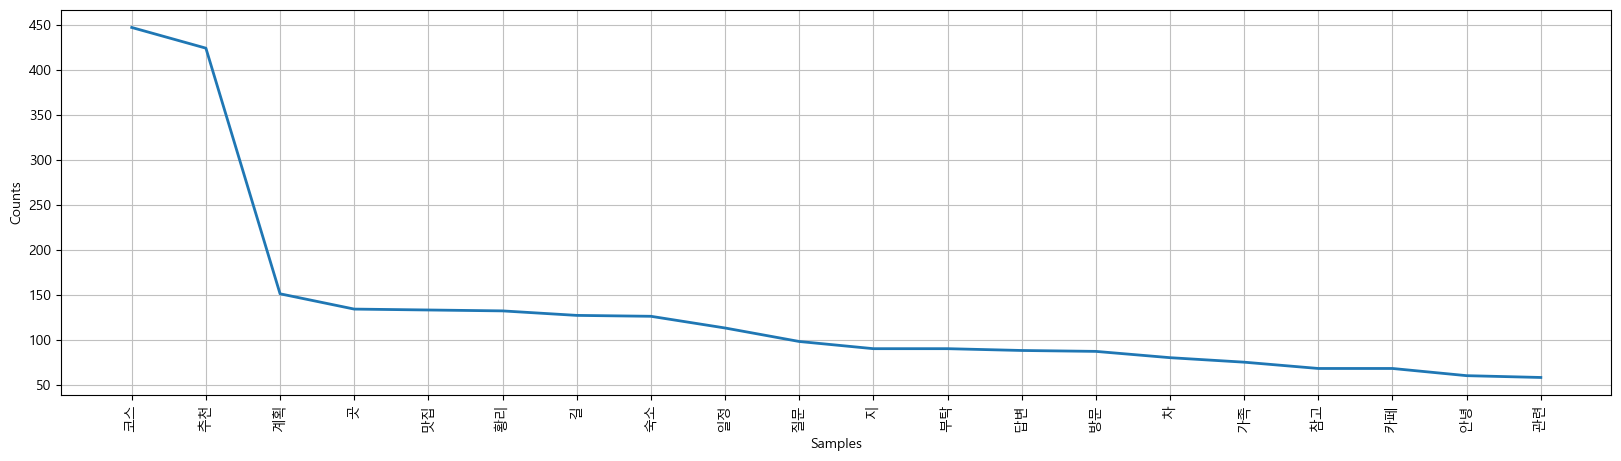

In [93]:
import nltk
data_text = nltk.Text(df_gj_noun_list)
plt.figure(figsize=(20,5))
plt.rc('font', family='Malgun Gothic')
data_text.plot(20)
plt.show()

In [ ]:
word, counts = zip(*data_text.vocab().most_common(20))
plt.figure(figsize=(20,5))
plt.plot(word, counts)
plt.xticks(rotation=45)
plt.x

# 6. 유사도 분석
## Word2Vec

In [94]:
df = pd.read_csv('data/naver.csv')
df.sample()

,query,no,title,link,description,total_text
201,전주 여행,202,전주 커플 여행 1박 2일 코스에 포함된 문화 체험 활동은...,https://kin.naver.com/qna/detail.naver?d1id=9&...,전주 여행 중 커플들이 함께 즐길 수 있는 문화 체험 활동에는 어떤 것들이 포함되...,전주 커플 여행 1박 2일 코스에 포함된 문화 체험 활동은... 전주 여행...


In [104]:
total_text_list = df['total_text'].to_list()
total_text_list[:2]

['25년10월5,6,7일  전주여행   전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가기 좋은 시점이에요 추석에는 문 연 곳이 적을 수 있지만 전주 한옥마을이나 전주비빔밥 맛집은 추천해용 차는 밀릴 가능성이 높으니 미리 출발하는 ',
 'KTX로 떠나는  전주 여행 , 주요 관광지 도보 이동...   전주 여행 계획 중이시군요 전주역에서 한옥마을까지는 사실 도보로는 좀 멀어요 약 3km 정도 되고 40분 정도 걸립니다 그래서 대부분 택시나 버스를 이용하시는데 택시는 10분 정도면 도착하고 요금도 7 8천원 정도로 부담 없어요 ']

In [107]:
from mecab import MeCab
select_pos = ['NNP', 'NNG']
불용어 = {'여행'}
analyzer = MeCab()
total_noun_list = []
for total_text in total_text_list:
    noun_list = [token for token, tag in analyzer.pos(total_text)
                    if tag in select_pos and
                        token not in 불용어 and
                        len(token)>1]
    total_noun_list.append(noun_list)
print(total_noun_list[:2])

[['전주', '전주', '추천', '부탁', '전주', '아이', '시점', '추석', '전주', '한옥마을', '전주비빔밥', '맛집', '추천', '해용', '가능', '출발'], ['전주', '주요', '관광지', '도보', '이동', '전주', '계획', '주역', '한옥마을', '도보', '정도', '정도', '대부분', '택시', '버스', '이용', '택시', '정도', '도착', '요금', '정도', '부담']]


In [108]:
from gensim.models import Word2Vec
model = Word2Vec(total_noun_list, window=10, min_count=2, workers=-1, sg=1) # 소량데이터

In [109]:
model.wv.most_similar('전주')

[('식사', 0.3595535457134247),
 ('동선', 0.2897421419620514),
 ('리스트', 0.275379478931427),
 ('덕진구', 0.2731468081474304),
 ('현재', 0.2580290138721466),
 ('가격', 0.2295033037662506),
 ('반려', 0.22023281455039978),
 ('답변', 0.21883943676948547),
 ('한옥마을', 0.21617142856121063),
 ('허락', 0.2135322391986847)]

In [110]:
model.wv.most_similar('경주')

[('호수', 0.3641005754470825),
 ('여름', 0.21867415308952332),
 ('배차', 0.21632219851016998),
 ('경기전', 0.2159893959760666),
 ('인근', 0.21469099819660187),
 ('황동', 0.2134207934141159),
 ('다랭이', 0.20914912223815918),
 ('봉길', 0.20906010270118713),
 ('남편', 0.2070489227771759),
 ('체계', 0.20607852935791016)]

## 연관분석

In [111]:
print(total_noun_list)

[['전주', '전주', '추천', '부탁', '전주', '아이', '시점', '추석', '전주', '한옥마을', '전주비빔밥', '맛집', '추천', '해용', '가능', '출발'], ['전주', '주요', '관광지', '도보', '이동', '전주', '계획', '주역', '한옥마을', '도보', '정도', '정도', '대부분', '택시', '버스', '이용', '택시', '정도', '도착', '요금', '정도', '부담'], ['아이', '전주', '중순', '아이', '당일치기', '전주', '전주', '처음', '식당', '중순', '아이', '전주', '당일치기', '아이', '부모'], ['전주', '커플', '코스', '포함', '문화', '체험', '활동', '전주', '커플', '문화', '체험', '활동', '포함', '한복', '대여', '전통', '공예', '체험', '특별', '경험', '가능', '프로그램', '추천', '한옥마을', '중심', '전통문화', '현대'], ['여학생', '친구', '전주', '안녕', '여학생', '친구', '전주', '일본', '애니', '전주', '오타쿠', '갈만'], ['전주', '전주', '사람', '호텔', '가격', '얼마', '정도', '맛집', '카페', '추천', '전주', '계획', '한옥', '마을', '근처'], ['전주', '맛집', '추천', '전주', '계획', '동안', '효율', '맛집', '포토', '스팟', '목대', '명소', '현지', '맛집', '정보', '일정', '포함', '추천'], ['전주', '지역', '특색', '음식', '전주', '음식', '비빔밥', '현지인', '맛집', '특별', '짬뽕', '한옥', '마을', '인근', '추천', '정도'], ['부모', '전주', '부모', '전주', '명소', '식당', '추천', '부탁', '전주', '한옥마을', '완산구', '덕진구', '추억', '장소'], ['전주', '맛집', '명소', '추천'

In [113]:
%%time
from apyori import apriori
rules = apriori(total_noun_list, min_support=0.15, min_confidence=0.3, min_lift=1)
rules = list(rules)
len(rules)

CPU times: total: 31.2 ms
Wall time: 34.9 ms


130

In [117]:
rules_df = pd.DataFrame(None, columns=['lhs', 'rhs', '지지도', '신뢰도', '향상도'])
rules_df

,lhs,rhs,지지도,신뢰도,향상도


In [120]:
idx = 0
for row in rules:
    support = row[1]
    ordered_st = row[2]
    for item in ordered_st:
        #print(item)
        lhs = item[0]
        lhs = ','.join([x for x in lhs])
        rhs = item[1]
        rhs = ','.join([x for x in rhs])
        confidence = item[2]
        lift = item[3]
        rules_df.loc[idx] = [lhs, rhs, support, confidence, lift]
        idx += 1
#         print("{:10}=>{:16}\t{}\t{}\t{:.2f}".format(lhs, rhs, support, 
#                                                 round(confidence, 2), 
#                                                 lift))
rules_df = rules_df.sort_values(by=['신뢰도', '향상도'], ascending=False)
rules_df.head(20)

,lhs,rhs,지지도,신뢰도,향상도
107,"여수,국내",티비,0.150,1.0,6.060606
137,"주달,국내",티비,0.155,1.0,6.060606
143,"국내,코스",티비,0.155,1.0,6.060606
167,"맛집,여수",티비,0.155,1.0,6.060606
233,"주달,여수",티비,0.155,1.0,6.060606
239,"여수,코스",티비,0.155,1.0,6.060606
312,"여수,국내","맛집,티비",0.150,1.0,6.060606
317,"맛집,여수,국내",티비,0.150,1.0,6.060606
382,"주달,국내","맛집,티비",0.155,1.0,6.060606
387,"맛집,주달,국내",티비,0.155,1.0,6.060606
